In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

### Loading the data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, 
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])), batch_size=64, shuffle=True, num_workers=4)

### Depicting spatial trasnformer networks

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        self.theta = theta.view(-1, 2, 3)
        
        self.grid = F.affine_grid(self.theta, x.size())
        x = F.grid_sample(x, self.grid)
        
        return x
    
    def forward(self, x):
        x = self.stn(x)
        
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net().to(device)

### Training the model

In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
            
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
             .format(test_loss, correct, len(test_loader.dataset),
                    100. * correct / len(test_loader.dataset)))

### Visualizing the STN result

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.277849
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.706351


/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2169, Accuracy: 9401/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.425963
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.325422

Test set: Average loss: 0.1261, Accuracy: 9627/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.265042
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.284905

Test set: Average loss: 0.1074, Accuracy: 9663/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.258070
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.090924

Test set: Average loss: 0.0869, Accuracy: 9747/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.160052
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.185635

Test set: Average loss: 0.0893, Accuracy: 9720/10000 (97%)



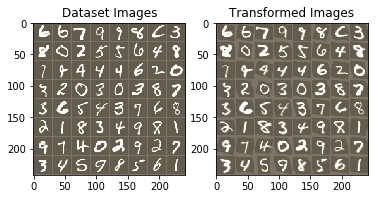

In [5]:
def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)
        
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))
        
        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        
for epoch in range(1, 5 + 1):
    train(epoch)
    test()
    
visualize_stn()

plt.ioff()
plt.show()

In [9]:
print('theta shape:', model.theta.shape)
print('theta:\n', model.theta[0])

print('grid shape:', model.grid.shape)
print('grid:\n', model.grid[0,:,:,0])

theta shape: torch.Size([64, 2, 3])
theta:
 tensor([[ 1.0516, -0.0050, -0.0080],
        [-0.1267,  1.1037, -0.0146]])
grid shape: torch.Size([64, 28, 28, 2])
grid:
 tensor([[-1.0546, -0.9768, -0.8989, -0.8210, -0.7431, -0.6652, -0.5873, -0.5094,
         -0.4315, -0.3536, -0.2757, -0.1978, -0.1199, -0.0420,  0.0359,  0.1138,
          0.1917,  0.2696,  0.3475,  0.4254,  0.5033,  0.5812,  0.6590,  0.7369,
          0.8148,  0.8927,  0.9706,  1.0485],
        [-1.0550, -0.9771, -0.8992, -0.8213, -0.7434, -0.6655, -0.5876, -0.5097,
         -0.4319, -0.3540, -0.2761, -0.1982, -0.1203, -0.0424,  0.0355,  0.1134,
          0.1913,  0.2692,  0.3471,  0.4250,  0.5029,  0.5808,  0.6587,  0.7366,
          0.8145,  0.8924,  0.9703,  1.0482],
        [-1.0554, -0.9775, -0.8996, -0.8217, -0.7438, -0.6659, -0.5880, -0.5101,
         -0.4322, -0.3543, -0.2764, -0.1985, -0.1206, -0.0427,  0.0352,  0.1130,
          0.1909,  0.2688,  0.3467,  0.4246,  0.5025,  0.5804,  0.6583,  0.7362,
          0.8